In [8]:
import os
import random
import time
from bisect import bisect_left

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from load_data import get_lidar, get_encoder, get_imu
from p3_util import replay_lidar
from MapUtils.bresenham2D import bresenham2D
from MapUtils.MapUtils import mapCorrelation, getMapCellsFromRay
# from MapUtilsCython.MapUtils_fclad import mapCorrelation_fclad

%matplotlib inline

### Load Training Data

In [9]:
dir_train_data = "./data/"
fnames = {'Encoders':[], 'Hokuyo': [], 'imu': []}
for name in np.array(os.listdir(dir_train_data)):
    for k in fnames.keys():
        if name.startswith(k):
            fnames[k].append(name.split(".")[0])
            continue
            
print(fnames)

{'Encoders': ['Encoders20', 'Encoders21', 'Encoders23'], 'Hokuyo': ['Hokuyo20', 'Hokuyo21', 'Hokuyo23'], 'imu': ['imu20', 'imu21', 'imu23']}


In [10]:
train_data = {}

def load_data(filename):
    fpath = os.path.join(dir_train_data, filename)
    if filename.startswith('Encoders'):
        return get_encoder(fpath)
    elif filename.startswith('Hokuyo'):
        return get_lidar(fpath)
    elif filename.startswith('imu'):
        return get_imu(fpath)
    else:
        print("Load data error:", filename)

for k, v in fnames.items():
    if k not in train_data:
        train_data[k] = {}

    for fname in v:
        train_data[k][fname] = load_data(fname)

for k in fnames.keys():
    print("-----------------", k, "-------------------")
    for key, val in train_data[k].items():
        print(key + ":", (len(val), len(val[0])))

----------------- Encoders -------------------
Encoders20: (5, 4956)
Encoders21: (5, 4789)
Encoders23: (5, 3809)
----------------- Hokuyo -------------------
Hokuyo20: (4962, 3)
Hokuyo21: (4785, 3)
Hokuyo23: (3803, 3)
----------------- imu -------------------
imu20: (7, 12187)
imu21: (7, 11730)
imu23: (7, 9416)


#### Lidar

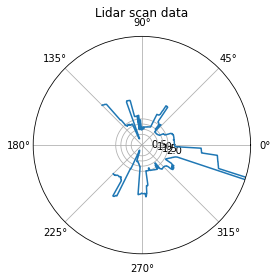

In [11]:
replay_lidar(train_data['Hokuyo']['Hokuyo20'][:210])

#### IMU

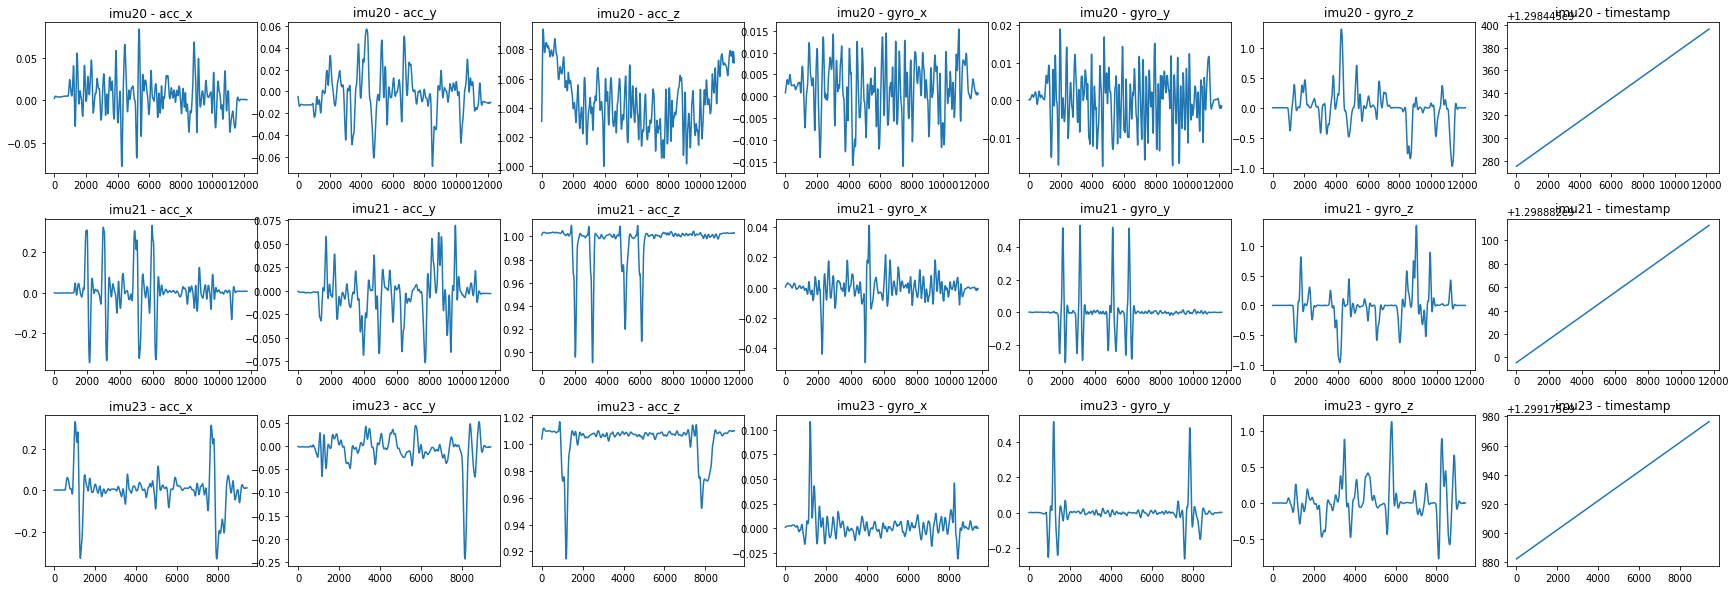

In [12]:
data = train_data["imu"]
titles = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z", "timestamp"]
PLT_COL = len(titles)
PLT_ROW = len(data)

plt.figure(figsize=[30, 10])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.3)

row, col = 0, 1
for k, v in data.items():
    col = 1
    for i in range(len(titles)):
        plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(k + " - " + titles[col - 1])
        plt.plot(v[i])
        col += 1
    row += 1

#### Encoder

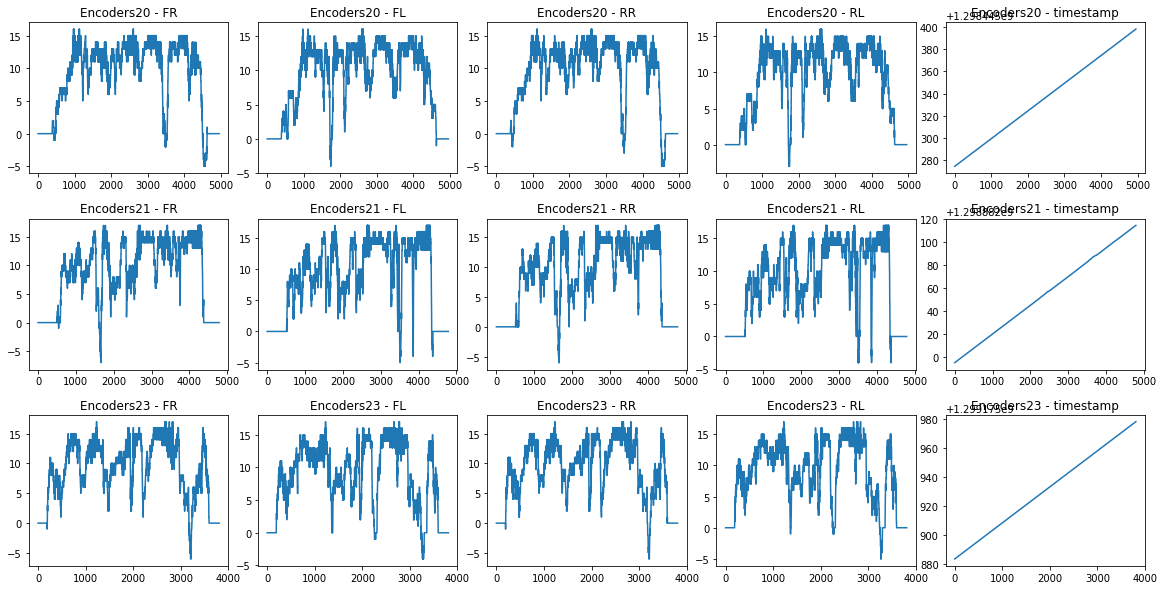

In [13]:
data = train_data["Encoders"]
titles = ["FR", "FL", "RR", "RL", "timestamp"]
PLT_COL = len(titles)
PLT_ROW = len(data)

plt.figure(figsize=[20, 10])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.3)

row, col = 0, 1
for k, v in data.items():
    col = 1
    for i in range(len(titles)):
        plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(k + " - " + titles[col - 1])
        plt.plot(v[i])
        col += 1
    row += 1

### Dead-reckoning method with Encoder data

In [14]:
'''
Δs = (Δr + Δl) / 2
Δθ = (Δr - Δl) / wheel_distance
Δx = Δs cos(θ + Δθ/2)
Δy = Δs sin(θ + Δθ/2)
'''
def getOdometry(data, sample_rate, offset=0):
    wheel_diameter = (584.2 - 330.2) / 1000.0 # meter
    wheel_distance = (311.15 + 476.25) / 2 / 1000.0 # meter
    distance = np.pi * wheel_diameter / 360  # 360 per revolution
    scale = 1.85
    
    right = data[0] * distance
    left  = data[1] * distance
    theta = (right - left) / wheel_distance / scale
    theta = np.add.accumulate(theta)
    x = ((right + left) / 2) * np.cos(theta)
    y = ((right + left) / 2) * np.sin(theta)
    xx = np.add.accumulate(x, axis=0)
    yy = np.add.accumulate(y, axis=0)
    
    return xx[offset::sample_rate], yy[offset::sample_rate], theta[offset::sample_rate], data[4][offset::sample_rate]

In [15]:
def getMatchedImuData(data, timestamps):
    ts_list = data[6]
    res = []
    for t in timestamps:
        idx = bisect_left(ts_list, t)
        if idx == 0:
            pass
        elif idx == len(ts_list):
            idx = len(ts_list) - 1
        elif abs(t - ts_list[idx - 1]) < abs(t - ts_list[idx]):
            idx -= 1        
        res.append(np.array([d[idx] for d in data]))
    return np.array(res)

def isTilted(gyro_y):
    return abs(gyro_y) > 0.03

In [16]:
def getMatchedLidarData(data, timestamps):
    ts_list = [d['t'] for d in data]
    res = []
    for t in timestamps:
        idx = bisect_left(ts_list, t)
        if idx == 0:
            pass
        elif idx == len(ts_list):
            idx = len(ts_list) - 1
        elif abs(t - ts_list[idx - 1]) < abs(t - ts_list[idx]):
            idx -= 1        
        res.append(data[idx])
    return np.array(res)    

In [17]:
def getStaticOffset(data):
    offset = 0
    for i in range(1, len(data[0])):
        if data[0][i] - data[0][i - 1] != 0:
            offset = i
            break
            
    return offset

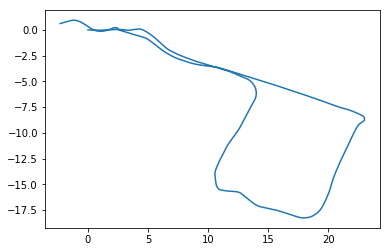

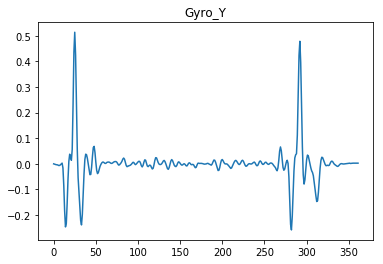

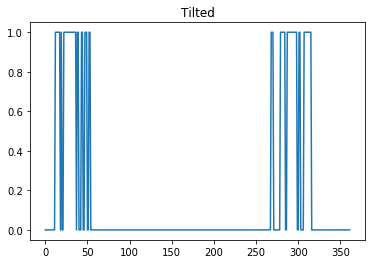

offset: 193
(362,) (362,) (362,) (362,)
(362,)


In [28]:
TEST_NO = "23"

encoders = train_data["Encoders"]["Encoders" + TEST_NO]
hokuyo = train_data["Hokuyo"]['Hokuyo' + TEST_NO]
imu = train_data["imu"]['imu' + TEST_NO]

sample_rate = 10
offset = getStaticOffset(encoders)
xs, ys, thetas, timestamps = getOdometry(encoders, sample_rate, offset)
lidars = getMatchedLidarData(hokuyo, timestamps)
imus = getMatchedImuData(imu, timestamps)
gyro_y = imus[:, 4]
tilted = isTilted(gyro_y)

plt.plot(xs, ys)
plt.show()

plt.plot(gyro_y)
plt.title("Gyro_Y")
plt.show()

plt.plot(tilted)
plt.title("Tilted")
plt.show()

print("offset:", offset)
print(xs.shape, ys.shape, thetas.shape, timestamps.shape)
print(lidars.shape)

In [36]:
class Slam:
    def __init__(self, n_data, lidar_angles, startingAngle, noise, log_probability, ocpy_thresh, empty_thresh, res=0.1, grid_size=1000, iters_start_map=0, n_particles=100):
        self.ocpy_prob = log_probability
        self.empty_prob = -log_probability
        self.ocpy_thresh = ocpy_thresh
        self.empty_thresh = empty_thresh
        
        self.res = res  # meter
        self.grid_size = grid_size
        self.grid_orig = self.grid_size // 2
        self.grid = np.zeros((self.grid_size, self.grid_size))
    
        self.n_data = n_data
        self.odometry_loc = np.zeros((n_data, 2))
        self.particle_loc = np.zeros((n_data, 2))
        
        self.iters = 0
        self.iters_start_map = iters_start_map
        
        # lidar
        self.lidar_angles = lidar_angles 
        self.startingAngle = startingAngle
        
        # particle filter
        self.n_particles = n_particles  # number of particles
        self.W = np.ones(n_particles) / n_particles  # initialize same prior
        self.particles = np.zeros((n_particles, 3))  # N, (x, y, theta)
        self.noise = noise  # (x, y, theta)
        self.prev_pose = None  # np.array[x, y, theta]
        
    
    def update(self, x, y, theta, scan, tilted):
        x = (x / self.res).astype(int) 
        y = (y / self.res).astype(int)
        
        if self.prev_pose is None:
            self.prev_pose = np.array([x, y, theta])
        
        cor_mle = self.__particle_predict(x, y, theta, scan)
        px, py, ptheta = self.__particle_update(x, y, theta, scan, cor_mle)
        
        x += self.grid_orig
        y += self.grid_orig
        px += self.grid_orig
        py += self.grid_orig
        
        if self.iters >= self.iters_start_map and not tilted:
            self.__grid_update(px, py, ptheta, scan)  
           
        self.odometry_loc[self.iters] = np.array([x, y])
        self.particle_loc[self.iters] = np.array([px, py])
          
        self.iters += 1
    
    
    def __particle_predict(self, x, y, theta, scan):
        if self.prev_pose is None:
            self.prev_pose = np.array([x, y, theta])
            return
        
        # particles
        pose = np.array([x, y, theta])
        pose_diff = pose - self.prev_pose
        self.prev_pose = pose
        self.particles += pose_diff + np.random.randn(self.n_particles, 3) * self.noise
        self.particles[:, 2] %= 2 * np.pi
         
        # index of x and y coordinate
        x_im = np.arange(self.grid_size)
        y_im = np.arange(self.grid_size)

        # 5x5 window
        xs = np.arange(-2 * self.res, 3 * self.res, self.res)
        ys = np.arange(-2 * self.res, 3 * self.res, self.res)
        
        # temp grid for computing map correlation
        grid = np.zeros_like(self.grid)
        grid[self.grid > self.ocpy_thresh] = 1
        grid[self.grid < self.empty_thresh] = -1

        # iterate N particles
        cor_mle = np.zeros(self.n_particles)
        for i in range(self.n_particles):
            # pose in world frame
            theta = (self.lidar_angles + self.particles[i][2]).reshape((-1, 1))
            px = scan * np.cos(theta) / self.res + self.grid_size // 2
            py = scan * np.sin(theta) / self.res + self.grid_size // 2
            
            # map correlation
            map_corr = mapCorrelation(grid, x_im, y_im, 
                                      np.vstack((px, py)), 
                                      self.particles[i][0] + xs, 
                                      self.particles[i][1] + ys)
            cor_mle[i] = np.max(map_corr)
        
        return cor_mle
        
    
    def __particle_update(self, x, y, theta, scan, cor_mle):
        cor_mle *= self.W
        self.W = self.__softmax(cor_mle)

        best_idx = np.argmax(self.W)
        px, py, ptheta = self.particles[best_idx]
        
        n_eff = 1 / (self.W ** 2).sum()
        if n_eff < 0.85 * self.n_particles:
            idx = self.__stratified_resample(self.W)
            self.particles[:] = self.particles[idx]
            self.W.fill(1.0 / self.n_particles)
        
        return int(px), int(py), ptheta 
    
        
    def __grid_update(self, x, y, theta, scan):
        cx, cy = self.__pol2cart(scan, theta)
        cx = (cx / self.res).astype(int)
        cy = (cy / self.res).astype(int)
        
        x_occ = cx + x
        y_occ = cy + y
        wall_set = np.zeros_like(self.grid) 
        for i in range(len(x_occ)):
            if 0 <= x_occ[i] < self.grid_size and 0 <= y_occ[i] < self.grid_size:
                wall_set[x_occ[i], y_occ[i]] = 1
 
        empty_set = np.zeros_like(self.grid)
        for i in range(len(x_occ)):
            line = np.array(bresenham2D(0, 0, cx[i], cy[i])).astype(int)
            line[0] += x
            line[1] += y
            for j in range(len(line[0]) - 1):
                if 0 <= line[0][j] < self.grid_size and 0 <= line[1][j] < self.grid_size:
                    empty_set[line[0][j], line[1][j]] = 1

        self.grid[wall_set == 1] += self.ocpy_prob
        self.grid[empty_set == 1] += self.empty_prob

        # pixel value
        self.grid[self.grid > 120] = 120
        self.grid[self.grid < -120] = -120
        
    
    def getResults(self):
        slam_map = np.zeros_like(self.grid)
        slam_map[self.grid > self.ocpy_thresh] = 1
        slam_map[self.grid < self.empty_thresh] = 0.65
        return slam_map, self.particle_loc, self.odometry_loc
    
  
    def __pol2cart(self, radius, theta):
        theta = np.arange(self.startingAngle, -self.startingAngle, -2 * self.startingAngle / len(radius)) + theta
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y
    
    
    def __softmax(self, z):
        exp_z = np.exp(z - np.max(z))
        return exp_z / np.sum(exp_z)
    
    
    def __stratified_resample(self, weights):
        N = len(weights)
        rng = (np.random.rand(N) + range(N)) / N
        cum_w = np.cumsum(weights)
        result = []
        i, j = 0, 0
        while i < N:
            if rng[i] < cum_w[j]:
                result.append(j)
                i += 1
            else:
                j += 1
        return np.array(result)

mapping starts: 18
draw intervals: 40


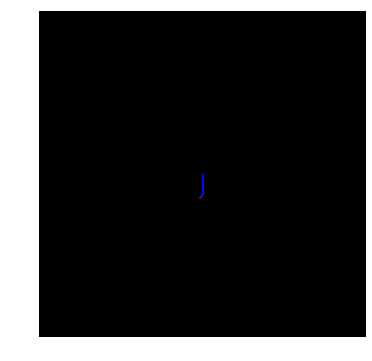

figure 39 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_39.png


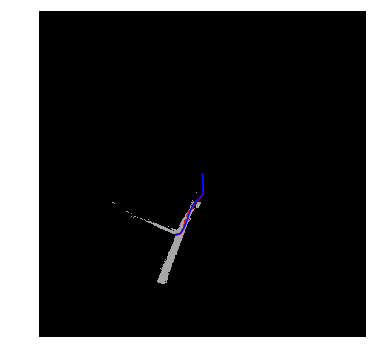

figure 79 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_79.png


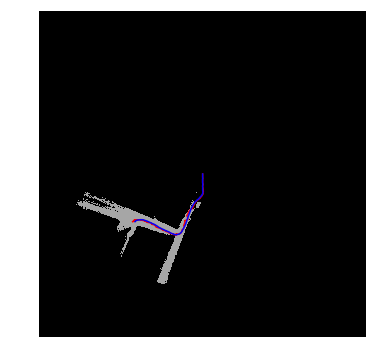

figure 119 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_119.png


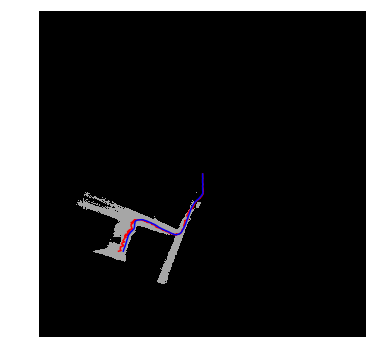

figure 159 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_159.png


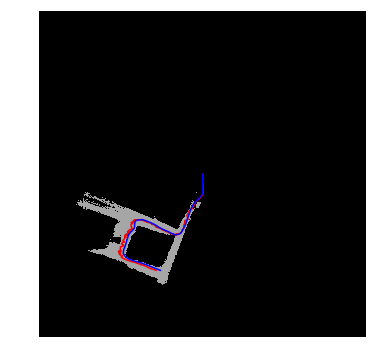

figure 199 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_199.png


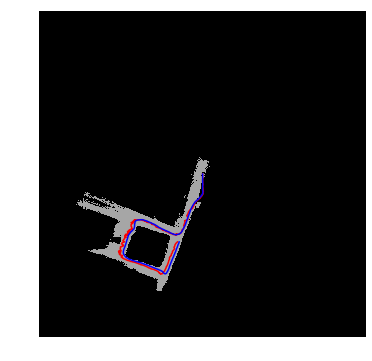

figure 239 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_239.png


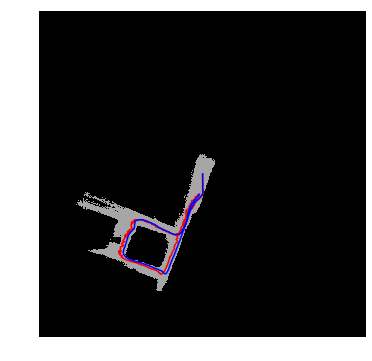

figure 279 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_279.png


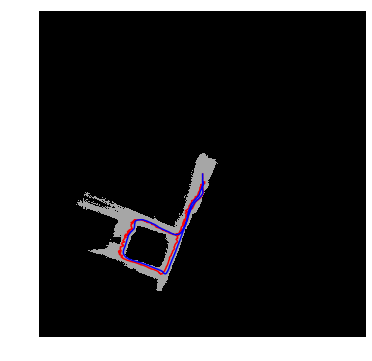

figure 319 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_319.png


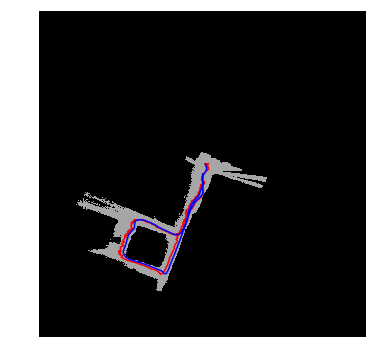

figure 359 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_359.png


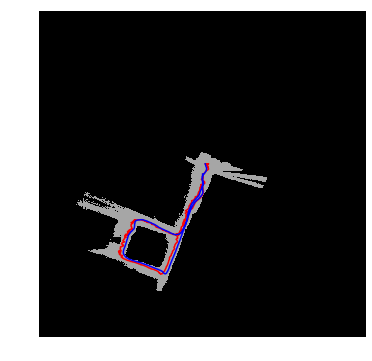

figure 361 is saved to results/23_0.05_1500_10_200_15.0_-15.0_0.5_361.png
CPU times: user 23min 49s, sys: 8min 34s, total: 32min 24s
Wall time: 32min 26s


In [37]:
%%time

RESULT_DIR = 'results/'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

n = len(xs)
res = 0.05
grid_size = 1500
lidar_angles = lidars[0]['angle']
lidar_starting_angle = -135 / 180 * np.pi
noise = np.array([0.5, 0.5, 0.1 * np.pi / 180]) # x, y, theta
log_prob = np.log(0.9/0.1)
particles = 200
iters_start_map = n // 20
draw_thresh = n // 9
ocpy_thresh = 150 / sample_rate
empty_thresh = -ocpy_thresh

print(f"mapping starts: {iters_start_map}")
print(f"draw intervals: {draw_thresh}")

slam = Slam(n, lidar_angles, lidar_starting_angle, noise, log_prob, ocpy_thresh, empty_thresh, res=0.05, grid_size=1500, iters_start_map=iters_start_map, n_particles=particles)
for i in range(n):
    slam.update(xs[i], ys[i], thetas[i], lidars[i]['scan'], tilted[i])
    if (i + 1) % draw_thresh == 0 or i == n - 1:
        slam_map, particle, odometry = slam.getResults()
        plt.figure(figsize=[6, 6])
        plt.axis('off')
        plt.imshow(slam_map, cmap='gray', vmin=0, vmax=1)
        plt.plot(particle[1:i, 1], odometry[1:i, 0], 'r-')
        plt.plot(odometry[1:i, 1], odometry[1:i, 0], 'b-')
        path = f'{RESULT_DIR}{TEST_NO}_{res}_{grid_size}_{sample_rate}_{particles}_{ocpy_thresh}_{empty_thresh}_{noise[0]}_{i}.png'
        plt.savefig(path)
        plt.show()
        plt.close()
        print(f"figure {i} is saved to", path)
        